# Differentially Private Provenance Graphs

## Run Algorithm

In [1]:
from pathlib import Path
import argparse
import yaml
import evaluate


graph_name = 'nd-134204506-processletevent'

epsilon_values = [0.001, 0.01, 0.1, 0.5, 1.0]
alpha_values = [0.025, 0.5, 1, 2, 3]

results = evaluate.main(
    input_directory = '../data/input',
    output_directory = '../data/output',
    graph_name = graph_name,
    epsilon_1_values = epsilon_values,
    epsilon_2_values = [1.0],
    alpha_values = alpha_values,
    num_samples = 50,
    parallel = True
)

(1.0,1.0,3.0): 100%|██████████| 50/50 [01:49<00:00,  2.20s/it]


## Create Graphs

In [8]:
import pandas as pd

df: pd.DataFrame = results.copy(deep=True)
df

,epsilon_1,epsilon_2,alpha,#pruned at depth=0,#pruned at depth=1,#pruned at depth=2,#pruned at depth=3,#pruned at depth=4,#pruned at depth=5,#pruned at depth=6,...,#edges kept avg,#edges kept stdev,#edges kept min,#edges kept max,#disconnected nodes avg,#disconnected nodes stdev,#disconnected nodes min,#disconnected nodes max,#pruned at depth=9,#pruned at depth=10
0,0.001,1.0,0.025,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,"{'[PROCESS_LET]-Access_File-[FILE]': 3700, '[P...","{'[FILE]-Access_File-[PROCESS_LET]': 7831, '[P...","{'[PROCESS_LET]-Access_File-[FILE]': 29670, '[...","{'[FILE]-Access_File-[PROCESS_LET]': 5878, '[P...","{'[PROCESS_LET]-Access_File-[FILE]': 20134, '[...","{'[FILE]-Access_File-[PROCESS_LET]': 673, '[FI...",...,540.92,318.580153,0,1206,1094.26,234.218856,541,1488,NaN,NaN
1,0.001,1.0,0.5,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,"{'[FILE]-Access_File-[PROCESS_LET]': 662, '[FI...","{'[PROCESS_LET]-Access_File-[FILE]': 443, '[FI...","{'[PROCESS_LET]-Access_File-[FILE]': 97622, '[...","{'[FILE]-Access_File-[PROCESS_LET]': 2533, '[P...","{'[PROCESS_LET]-Access_File-[FILE]': 276, '[FI...",{'[FILE]-Execute_Processlet_Library-[PROCESS_L...,...,867.64,215.242539,657,1295,890.74,203.179311,488,1084,{'[PROCESS_LET]-Access_File-[FILE]': 4},NaN
2,0.001,1.0,1.0,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,"{'[PROCESS_LET]-Access_File-[FILE]': 1978, '[P...","{'[FILE]-Access_File-[PROCESS_LET]': 11762, '[...","{'[PROCESS_LET]-Access_File-[FILE]': 50115, '[...","{'[PROCESS_LET]-Access_File-[FILE]': 172, '[FI...","{'[FILE]-Access_File-[PROCESS_LET]': 1690, '[F...","{'[PROCESS_LET]-Access_File-[FILE]': 2, '[FILE...",...,1073.5,226.512715,782,1414,762.98,215.930868,435,1029,NaN,NaN
3,0.001,1.0,2.0,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,"{'[FILE]-Access_File-[PROCESS_LET]': 1086, '[F...","{'[PROCESS_LET]-Access_File-[FILE]': 801, '[FI...","{'[FILE]-Access_File-[PROCESS_LET]': 19001, '[...","{'[PROCESS_LET]-Access_File-[FILE]': 175, '[FI...","{'[FILE]-Access_File-[PROCESS_LET]': 2854, '[F...","{'[PROCESS_LET]-Access_File-[FILE]': 80, '[FIL...",...,1496.54,143.50989,985,1604,463.0,135.170115,357,945,"{'[FILE]-Access_File-[PROCESS_LET]': 85, '[PRO...",{'[PROCESS_LET]-Access_File-[FILE]': 1}
4,0.001,1.0,3.0,NaN,{'[FILE]-Execute_Processlet_Library-[PROCESS_L...,"{'[PROCESS_LET]-Access_File-[FILE]': 785, '[FI...","{'[FILE]-Access_File-[PROCESS_LET]': 24531, '[...","{'[FILE]-Access_File-[PROCESS_LET]': 3104, '[P...","{'[FILE]-Access_File-[PROCESS_LET]': 1735, '[F...","{'[FILE]-Access_File-[PROCESS_LET]': 587, '[PR...",...,1588.96,22.353487,1515,1625,385.44,18.798042,354,444,NaN,NaN
5,0.01,1.0,0.025,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,"{'[PROCESS_LET]-Access_File-[FILE]': 4492, '[P...","{'[FILE]-Access_File-[PROCESS_LET]': 9175, '[P...","{'[PROCESS_LET]-Access_File-[FILE]': 33195, '[...","{'[FILE]-Access_File-[PROCESS_LET]': 7501, '[P...","{'[PROCESS_LET]-Access_File-[FILE]': 27280, '[...","{'[FILE]-Access_File-[PROCESS_LET]': 347, '[PR...",...,629.3,303.361913,0,1136,1039.18,224.842228,576,1488,NaN,NaN
6,0.01,1.0,0.5,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,{'[FILE]-Execute_Processlet_Library-[PROCESS_L...,"{'[PROCESS_LET]-Access_File-[FILE]': 616, '[FI...","{'[FILE]-Access_File-[PROCESS_LET]': 18215, '[...","{'[FILE]-Access_File-[PROCESS_LET]': 3094, '[F...","{'[PROCESS_LET]-Access_File-[FILE]': 174, '[FI...","{'[FILE]-Access_File-[PROCESS_LET]': 900, '[FI...",...,1163.32,156.854001,684,1313,611.58,148.361058,486,1076,NaN,NaN
7,0.01,1.0,1.0,NaN,{'[FILE]-Execute_Processlet_Library-[PROCESS_L...,"{'[PROCESS_LET]-Access_File-[FILE]': 872, '[FI...","{'[FILE]-Access_File-[PROCESS_LET]': 24627, '[...","{'[FILE]-Access_File-[PROCESS_LET]': 3389, '[F...","{'[FILE]-Access_File-[PROCESS_LET]': 2054, '[F...","{'[PROCESS_LET]-Access_File-[FILE]': 33, '[FIL...",...,1395.18,34.747483,1217,1446,461.42,29.685747,420,613,NaN,NaN
8,0.01,1.0,2.0,NaN,"{'[FILE]-Access_File-[PROCESS_LET]': 1077, '[F

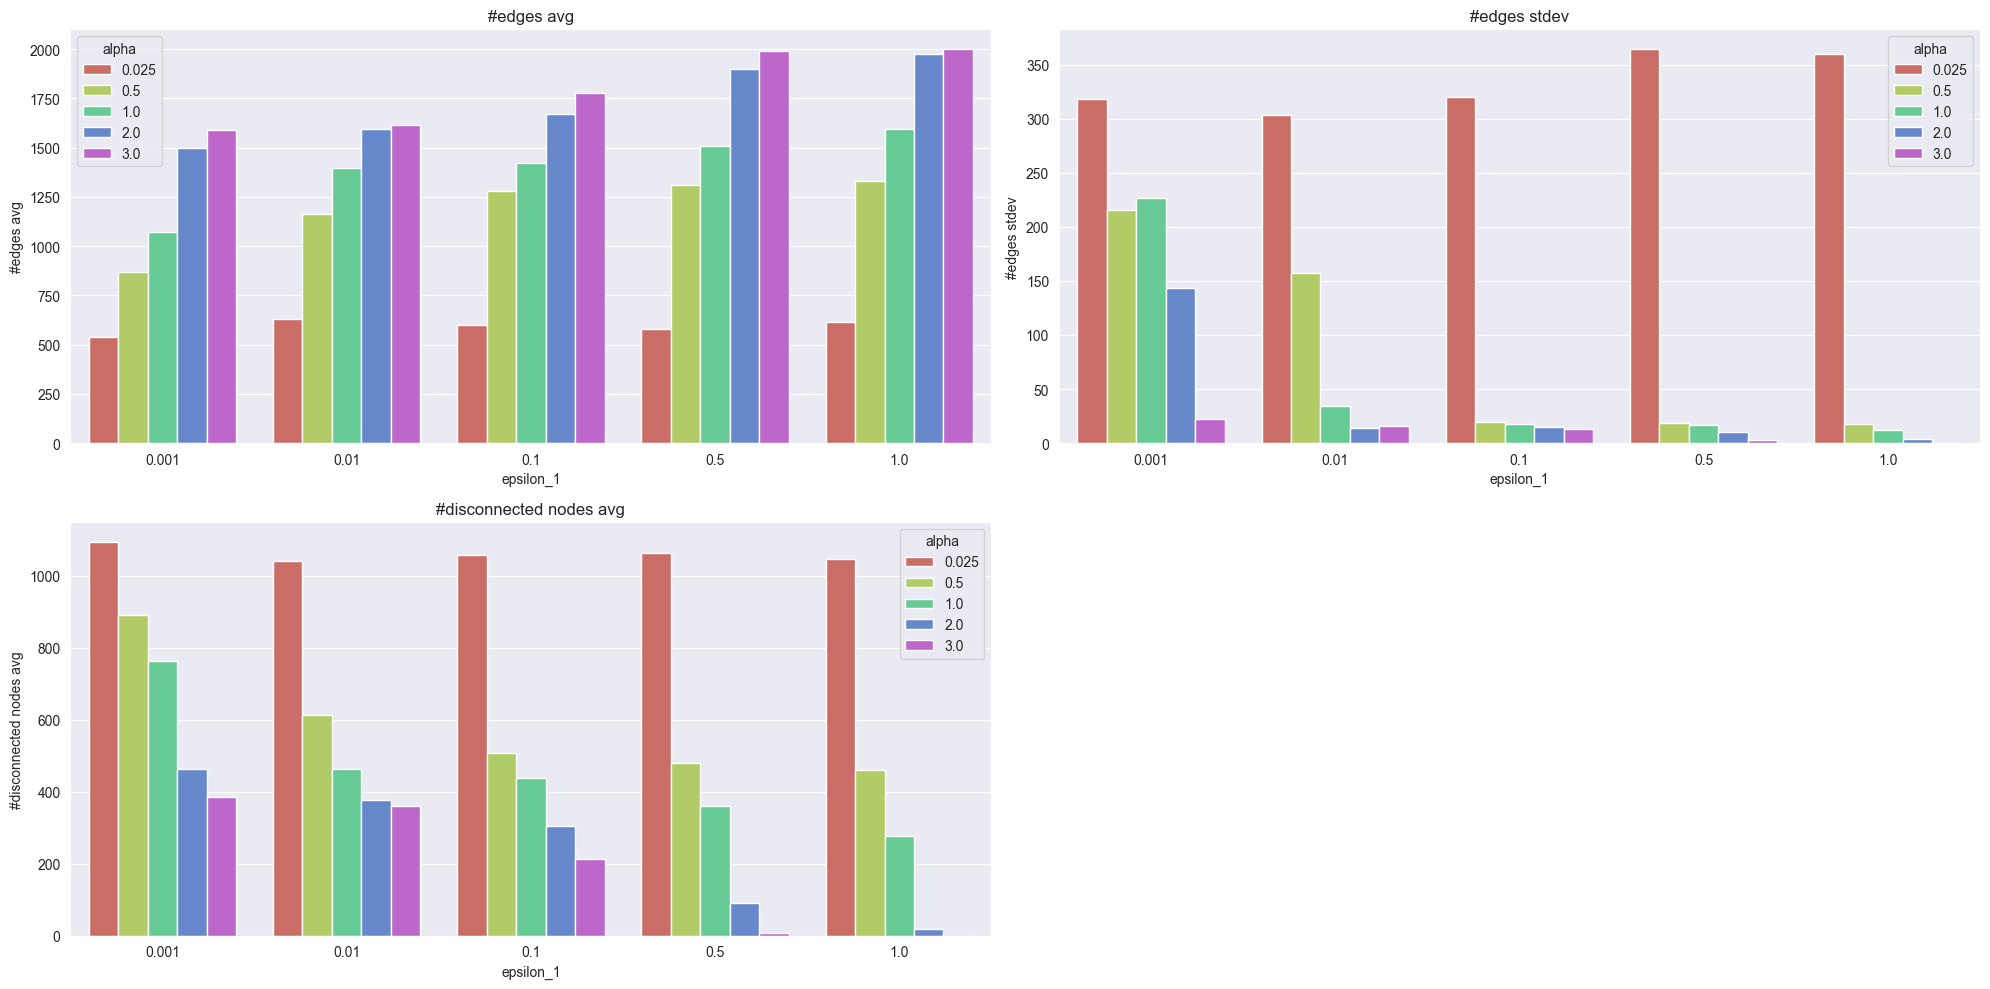

In [6]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

stats = ['#edges avg', '#edges stdev', '#disconnected nodes avg']
cols = 2
rows = math.ceil(len(stats) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()
def create_figure(x_column: str, y_column: str, ax: plt.Axes):
    palette = sns.color_palette('hls', len(df['alpha'].unique()))
    sns.barplot(data=df,
                x=x_column,
                y=y_column,
                ax=ax,
                hue='alpha',
                palette=palette)
    ax.set_title(y_column)

for i, stat in enumerate(stats):
    create_figure('epsilon_1', stat, axes[i])
for j in range(i + 1, rows * cols):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

## Average number of nodes pruned by depth

In [35]:
from collections import Counter
import plotly.express as px
from algorithm import PRUNED_AT_DEPTH

id_vars = ['epsilon_1', 'alpha']
depth_df = df.loc[:,id_vars]
depth_values = []
def sum_counter(counter: Counter):
    if not isinstance(counter, Counter):
        return 0
    return sum(counter.values())
for column in df.columns:
    if column.startswith(PRUNED_AT_DEPTH):
        depth = column[len(PRUNED_AT_DEPTH)+1:]
        depth_values.append(depth)
        depth_df[depth] = df[column].apply(sum_counter)
        
        
id_vars = ['epsilon_1', 'alpha']
depth_df = depth_df.melt(id_vars=id_vars,
              value_vars=depth_values,
              var_name='depth',
              value_name='#pruned').sort_values(id_vars)

In [54]:
import numpy as np
depth_df['depth'] = depth_df['depth'].astype(int)
depth_df['alpha'] = depth_df['alpha'].astype(str)
depth_df['%pruned'] = depth_df.groupby(['epsilon_1', 'alpha'])['#pruned'].transform(lambda x: x / x.sum())
depth_df['%pruned'] = depth_df['%pruned'].apply(lambda p: np.round(p, 3))
fig = px.bar(
    depth_df,
    x='alpha', y='%pruned',
    facet_col='epsilon_1',
    color='depth',
    text='%pruned',
    text_auto=True,
    labels={'epsilon_1': 'epsilon'}
)
fig.show()

In [55]:
df.to_csv(f'../data/output/{graph_name}/processed_stats.csv', index=False)